In [ ]:
!pip install datasets openpyxl transformers torch tiktoken verovio torchvision

In [ ]:
!unzip /content/License-Characters-by-2-27classes.zip -d /content/Dataset/

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorForSeq2Seq
import torch

import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

from tensorflow.keras.models import load_model
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import xml.etree.ElementTree as ET

import cv2

from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from transformers import AutoModel, AutoTokenizer, pipeline


In [ ]:
xml_dir = '/content/Dataset/License-Characters-by-2-27classes/train'
image_dir = '/content/Dataset/License-Characters-by-2-27classes/train'

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find('filename').text

    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)

    return filename, labels

def has_three_alphabets(labels):
    alphabet_count = sum([1 for label in labels if label.isalpha()])
    return alphabet_count == 3

image_labels = []
for xml_filename in os.listdir(xml_dir):
    if xml_filename.endswith('.xml'):
        xml_file_path = os.path.join(xml_dir, xml_filename)

        image_filename, labels = parse_xml(xml_file_path)

        if has_three_alphabets(labels):
            image_path = os.path.join(image_dir, image_filename)
            image_labels.append((image_path, labels))

In [ ]:
image_paths = [x[0] for x in image_labels]
# Join the character lists into strings
labels = [''.join(x[1]) for x in image_labels]

# Tokenize the labels to ensure uniform length (max length 128 here)
# tokenized_labels = [tokenizer.encode(label, padding='max_length', truncation=True, max_length=128) for label in labels]


In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.1/875.1 kB 42.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.7/112.6 GB disk)


In [ ]:
ipaths=[]
tpaths=[]
for dirname, _, filenames in os.walk('/content/Dataset/License-Characters-by-2-27classes/train'):
    for filename in filenames:
        if filename[-4:]=='jpeg':
            ipaths+=[os.path.join(dirname, filename)]
        elif filename[-4:]=='.txt':
            tpaths+=[os.path.join(dirname, filename)]
ipaths=sorted(ipaths)
tpaths=sorted(tpaths)

In [ ]:
boxdata=[]
boxfile=[]
for i in range(len(tpaths)):
    file=tpaths[i]
    boxdata+=[np.loadtxt(file)]
    boxfile+=[file[0:-4].split('/')[-1]]
print(boxdata[0])

[[          0     0.11488     0.56364    0.041575     0.61818]
 [          5     0.19803     0.52727    0.041575     0.67273]
 [          2     0.28884     0.49545     0.04814     0.75455]
 [          8     0.37856     0.49091     0.04814     0.74545]
 [         18     0.58972     0.50455    0.054705     0.73636]
 [         23     0.67943     0.50909    0.050328     0.70909]
 [         25     0.76696     0.53636    0.054705     0.69091]]


In [ ]:
BOX=pd.DataFrame()

for i in range(len(boxdata)):
    if type(boxdata[i][0])==np.float64:
        add=pd.DataFrame([boxdata[i]])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])
    else:
        add=pd.DataFrame(boxdata[i])
        add[5]=boxfile[i]
        BOX=pd.concat([BOX,add])

BOX2=BOX.reset_index(drop=True)
display(BOX2)
print(BOX2.iloc[:,0].max())

,0,1,2,3,4,5
0,0.0,0.114880,0.563636,0.041575,0.618182,ckictsenl0000246a2itn28ts
1,5.0,0.198031,0.527273,0.041575,0.672727,ckictsenl0000246a2itn28ts
2,2.0,0.288840,0.495455,0.048140,0.754545,ckictsenl0000246a2itn28ts
3,8.0,0.378556,0.490909,0.048140,0.745455,ckictsenl0000246a2itn28ts
4,18.0,0.589716,0.504545,0.054705,0.736364,ckictsenl0000246a2itn28ts
...,...,...,...,...,...,...
3808,4.0,0.418367,0.534247,0.102041,0.602740,ckn7dpc87001w3h66nfp0otgl
3809,9.0,0.540816,0.554795,0.102041,0.616438,ckn7dpc87001w3h66nfp0otgl
3810,23.0,0.693878,0.561644,0.102041,0.547945,ckn7dpc87001w3h66nfp0otgl
3811,12.0,0.821429,0.595890,0.091837,0.506849,ckn7dpc87001w3h66nfp0otgl


26.0


In [ ]:
N=list(range(27))
Name=[]
for i in range(27):
    Name+=[str(i).zfill(2)]
class_map=dict(zip(N,Name))

In [ ]:
for i in range(len(BOX2)):
    BOX2.iloc[i,0]=class_map[int(BOX2.iloc[i,0])]
display(BOX2)
display(BOX2.iloc[:,0].value_counts())

<ipython-input-10-f249c5bb189d>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  BOX2.iloc[i,0]=class_map[int(BOX2.iloc[i,0])]


,0,1,2,3,4,5
0,00,0.114880,0.563636,0.041575,0.618182,ckictsenl0000246a2itn28ts
1,05,0.198031,0.527273,0.041575,0.672727,ckictsenl0000246a2itn28ts
2,02,0.288840,0.495455,0.048140,0.754545,ckictsenl0000246a2itn28ts
3,08,0.378556,0.490909,0.048140,0.745455,ckictsenl0000246a2itn28ts
4,18,0.589716,0.504545,0.054705,0.736364,ckictsenl0000246a2itn28ts
...,...,...,...,...,...,...
3808,04,0.418367,0.534247,0.102041,0.602740,ckn7dpc87001w3h66nfp0otgl
3809,09,0.540816,0.554795,0.102041,0.616438,ckn7dpc87001w3h66nfp0otgl
3810,23,0.693878,0.561644,0.102041,0.547945,ckn7dpc87001w3h66nfp0otgl
3811,12,0.821429,0.595890,0.091837,0.506849,ckn7dpc87001w3h66nfp0otgl


,count
0,
07,276
03,269
05,262
16,249
02,245
00,225
04,225
09,203
12,199


In [ ]:
def draw_box(n0):

    ipath=ipaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath[0:-4].split('/')[-1]

    if BOX2[BOX2[5]==file] is not None:
        box=BOX2[BOX2[5]==file]
        box=box.reset_index(drop=True)

        for i in range(len(box)):
            label=box.iloc[i,0]
            x=box.iloc[i,1]
            y=box.iloc[i,2]
            w=box.iloc[i,3]
            h=box.iloc[i,4]
            x0=((x-w/2)*W).astype(int)
            y0=((y-h/2)*H).astype(int)
            x1=((x+w/2)*W).astype(int)
            y1=((y+h/2)*H).astype(int)
            cv2.rectangle(image,(x0,y0),(x1,y1),(0,255,0),1) #green

    #plt.imshow(image)
    #plt.show()

    return image

In [ ]:
images1=[]
for i in tqdm(range(len(ipaths))):#
    images1+=[draw_box(i)]

100%|██████████| 454/454 [00:01<00:00, 431.51it/s]


In [ ]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

In [ ]:
for i in range(len(ipaths)):
    ipath=ipaths[i]
    ifile=ipath.split('/')[-1]
    tpath=tpaths[i]
    tfile=tpath.split('/')[-1]
    if i%4==1:
        copyfile(ipath, f'datasets/valid/{ifile}')
        copyfile(tpath, f'datasets/valid/{tfile}')
    elif i%4==2:
        copyfile(ipath, f'datasets/test/{ifile}')
        #copyfile(tpath, f'datasets/test/{tfile}')
    else:
        copyfile(ipath, f'datasets/train/{ifile}')
        copyfile(tpath, f'datasets/train/{tfile}')

In [ ]:
import yaml

plate_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =27,
    names = Name
)

with open('plate.yaml', 'w') as outfile:
    yaml.dump(plate_yaml, outfile, default_flow_style=True)

%cat plate.yaml

{names: ['00', '01', '02', '03', '04', '05', '06', '07', 08, 09, '10', '11', '12',
    '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
    '26'], nc: 27, test: test, train: train, val: valid}


In [ ]:
model = YOLO("yolov8x.pt")


100%|██████████| 131M/131M [00:01<00:00, 94.6MB/s]


In [ ]:
!yolo task=detect mode=train model=yolov8x.pt data=plate.yaml epochs=40 imgsz=640

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=plate.yaml, epochs=40, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

In [ ]:
tpaths2=[]
for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/train'):
    for filename in filenames:
        if filename[-4:]=='.png' or filename[-4:]=='.jpg':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)

In [ ]:
for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

In [ ]:
best_path0='runs/detect/train/weights/best.pt'
source0='datasets/test'

In [ ]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='jpeg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(ppaths)

['datasets/test/ckictycsy0002246ajt63dkm5.jpeg', 'datasets/test/ckicu74au0006246a2o83cezi.jpeg', 'datasets/test/ckicuhdif000b246a6jak4g6p.jpeg', 'datasets/test/ckicup6z1000g246a7fphj2ry.jpeg', 'datasets/test/ckicvb7gq000k246aodh6vpdd.jpeg', 'datasets/test/ckicxizmk000q246ar1j99jy3.jpeg', 'datasets/test/ckicxt0op000u246alg56ihkb.jpeg', 'datasets/test/ckicy0gdl0010246aqtbhsypi.jpeg', 'datasets/test/ckicy67w80014246a06offtl7.jpeg', 'datasets/test/ckicyqnz2001c246az55zrhah.jpeg', 'datasets/test/ckicyxz7e001h246ap9zmlbb8.jpeg', 'datasets/test/ckicz3yrj001l246a28z89org.jpeg', 'datasets/test/ckiczdqyn001q246au8m6yybo.jpeg', 'datasets/test/ckicznjdl001x246a6u2mmuw0.jpeg', 'datasets/test/ckiczsqt30021246at3gyxfcb.jpeg', 'datasets/test/ckiczyhvx0025246aw1urmz65.jpeg', 'datasets/test/ckid07ja6002b246aqlofxau6.jpeg', 'datasets/test/ckid0gu9c002i246a90xe99zp.jpeg', 'datasets/test/ckid0mio0002m246adn07btx6.jpeg', 'datasets/test/ckid0s182002q246a04leqzk8.jpeg', 'datasets/test/ckid0x83t002u246an9q1fdz

In [ ]:
model2 = YOLO(best_path0)

In [ ]:
!yolo task=detect mode=predict model={best_path0} conf=0.01 source={source0}

Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,149,569 parameters, 0 gradients, 257.5 GFLOPs

image 1/113 /content/datasets/test/ckictycsy0002246ajt63dkm5.jpeg: 352x640 1 00, 1 03, 1 06, 1 09, 1 10, 1 11, 1 16, 75.9ms
image 2/113 /content/datasets/test/ckicu74au0006246a2o83cezi.jpeg: 320x640 1 01, 1 03, 2 08s, 2 10s, 1 15, 1 22, 51.7ms
image 3/113 /content/datasets/test/ckicuhdif000b246a6jak4g6p.jpeg: 352x640 1 00, 1 03, 1 06, 1 09, 1 10, 1 11, 1 16, 51.7ms
image 4/113 /content/datasets/test/ckicup6z1000g246a7fphj2ry.jpeg: 320x640 1 00, 1 04, 2 06s, 2 10s, 1 16, 49.4ms
image 5/113 /content/datasets/test/ckicvb7gq000k246aodh6vpdd.jpeg: 352x640 1 04, 2 05s, 1 06, 2 10s, 49.7ms
image 6/113 /content/datasets/test/ckicxizmk000q246ar1j99jy3.jpeg: 352x640 2 04s, 1 05, 1 09, 1 10, 1 11, 1 25, 34.4ms
image 7/113 /content/datasets/test/ckicxt0op000u246alg56ihkb.jpeg: 320x640 1 03, 1 04, 1 05, 1 09, 1 16, 1 18, 1 24, 3

In [ ]:
model2.save('yolo_model.pt')

In [ ]:
results = model2.predict(source0,conf=0.01)
print(len(results))


image 1/113 /content/datasets/test/ckictycsy0002246ajt63dkm5.jpeg: 352x640 1 00, 1 03, 1 06, 1 09, 1 10, 1 11, 1 16, 64.1ms
image 2/113 /content/datasets/test/ckicu74au0006246a2o83cezi.jpeg: 320x640 1 01, 1 03, 2 08s, 2 10s, 1 15, 1 22, 59.9ms
image 3/113 /content/datasets/test/ckicuhdif000b246a6jak4g6p.jpeg: 352x640 1 00, 1 03, 1 06, 1 09, 1 10, 1 11, 1 16, 67.1ms
image 4/113 /content/datasets/test/ckicup6z1000g246a7fphj2ry.jpeg: 320x640 1 00, 1 04, 2 06s, 2 10s, 1 16, 46.3ms
image 5/113 /content/datasets/test/ckicvb7gq000k246aodh6vpdd.jpeg: 352x640 1 04, 2 05s, 1 06, 2 10s, 44.6ms
image 6/113 /content/datasets/test/ckicxizmk000q246ar1j99jy3.jpeg: 352x640 2 04s, 1 05, 1 09, 1 10, 1 11, 1 25, 36.8ms
image 7/113 /content/datasets/test/ckicxt0op000u246alg56ihkb.jpeg: 320x640 1 03, 1 04, 1 05, 1 09, 1 16, 1 18, 1 24, 36.1ms
image 8/113 /content/datasets/test/ckicy0gdl0010246aqtbhsypi.jpeg: 352x640 1 01, 1 21, 37.8ms
image 9/113 /content/datasets/test/ckicy67w80014246a06offtl7.jpeg: 352x6

In [ ]:
print(results[0].boxes.data)

tensor([[194.1882,  37.0710, 218.7564, 137.3993,   0.9432,  11.0000],
        [ 80.6864,  13.9073, 110.0835, 146.9636,   0.9407,   9.0000],
        [115.0572,  37.0158, 142.5913, 146.7489,   0.9276,   0.0000],
        [ 12.7867,  14.6758,  43.0046, 146.6565,   0.9186,   3.0000],
        [ 46.1838,  14.8182,  75.9126, 147.0229,   0.8934,   6.0000],
        [159.9824,  25.9482, 185.1373, 136.9141,   0.8373,  16.0000],
        [227.4763,  25.7351, 250.0339, 137.4173,   0.6577,  10.0000]], device='cuda:0')


In [ ]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):#len(results)
    if len(results[i].boxes.data)>0:
        arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
        path=ppaths[i]
        file=path.split('/')[-1]
        arri=arri.assign(file=file)
        arri=arri.assign(i=i)
        PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

<ipython-input-30-b39d6d0da38d>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  PBOX=pd.concat([PBOX,arri],axis=0)


,x,y,x2,y2,confidence,class,file,i
0,194.188232,37.071018,218.756439,137.399338,0.943237,11.0,ckictycsy0002246ajt63dkm5.jpeg,0.0
1,80.686409,13.907321,110.083496,146.963623,0.940658,9.0,ckictycsy0002246ajt63dkm5.jpeg,0.0
2,115.057152,37.015839,142.591278,146.748886,0.927594,0.0,ckictycsy0002246ajt63dkm5.jpeg,0.0
3,12.786696,14.675763,43.004639,146.656464,0.918566,3.0,ckictycsy0002246ajt63dkm5.jpeg,0.0
4,46.183838,14.818217,75.912567,147.022919,0.893368,6.0,ckictycsy0002246ajt63dkm5.jpeg,0.0
...,...,...,...,...,...,...,...,...
3,2.180091,0.000000,19.913948,35.750156,0.026812,1.0,ckn7d1d5m00733h66am8f9050.jpeg,107.0
4,2.129076,0.000000,19.849710,34.130966,0.026811,7.0,ckn7d1d5m00733h66am8f9050.jpeg,107.0
5,31.775484,0.000000,47.413246,37.115368,0.014013,7.0,ckn7d1d5m00733h66am8f9050.jpeg,107.0
6,58.899647,0.000000,78.705086,39.819271,0.010953,22.0,ckn7d1d5m00733h66am8f9050.jpeg,107.0


In [ ]:
PBOX['class']=PBOX['class'].apply(lambda x: class_map[int(x)])
PBOX=PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

,x,y,x2,y2,confidence,class,file,i
0,194.188232,37.071018,218.756439,137.399338,0.943237,11,ckictycsy0002246ajt63dkm5.jpeg,0.0
1,80.686409,13.907321,110.083496,146.963623,0.940658,09,ckictycsy0002246ajt63dkm5.jpeg,0.0
2,115.057152,37.015839,142.591278,146.748886,0.927594,00,ckictycsy0002246ajt63dkm5.jpeg,0.0
3,12.786696,14.675763,43.004639,146.656464,0.918566,03,ckictycsy0002246ajt63dkm5.jpeg,0.0
4,46.183838,14.818217,75.912567,147.022919,0.893368,06,ckictycsy0002246ajt63dkm5.jpeg,0.0
...,...,...,...,...,...,...,...,...
745,2.180091,0.000000,19.913948,35.750156,0.026812,01,ckn7d1d5m00733h66am8f9050.jpeg,107.0
746,2.129076,0.000000,19.849710,34.130966,0.026811,07,ckn7d1d5m00733h66am8f9050.jpeg,107.0
747,31.775484,0.000000,47.413246,37.115368,0.014013,07,ckn7d1d5m00733h66am8f9050.jpeg,107.0
748,58.899647,0.000000,78.705086,39.819271,0.010953,22,ckn7d1d5m00733h66am8f9050.jpeg,107.0


,count
class,
07,71
16,62
04,58
03,45
09,43
08,43
00,40
12,39
11,37


In [ ]:
color_codes = [
    '#FF0000',  # Red
    '#FF4500',  # OrangeRed
    '#FF8C00',  # DarkOrange
    '#FFA500',  # Orange
    '#FFD700',  # Gold
    '#FFFF00',  # Yellow
    '#ADFF2F',  # GreenYellow
    '#7FFF00',  # Chartreuse
    '#00FF00',  # Lime
    '#00FA9A',  # MediumSpringGreen
    '#00FFFF',  # Cyan
    '#00BFFF',  # DeepSkyBlue
    '#0000FF',  # Blue
    '#8A2BE2'   # BlueViolet
]
colors=[]
for c in color_codes:
    colors += [tuple((int(c[1:3],16),int(c[3:5],16),int(c[5:7],16)))]

In [ ]:
def draw_box2(n0):

    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]

    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.iloc[i,5]
            x=int(box.iloc[i,0])
            y=int(box.iloc[i,1])
            x2=int(box.iloc[i,2])
            y2=int(box.iloc[i,3])
            #print(label,x,y,x2,y2)
            ci=colors[int(label)%14]
            cv2.rectangle(image,(x,y),(x2,y2),ci,1)

    #plt.imshow(image)
    #plt.show()

    return image

In [ ]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

100%|██████████| 113/113 [00:00<00:00, 275.11it/s]


array([[[ 42,  48,  55],
        [ 35,  41,  48],
        [ 27,  33,  40],
        ...,
        [ 83, 102, 117],
        [ 84, 103, 118],
        [ 87, 106, 121]],

       [[ 31,  37,  44],
        [ 29,  35,  42],
        [ 26,  32,  39],
        ...,
        [ 82, 101, 116],
        [ 82, 101, 116],
        [ 85, 104, 119]],

       [[ 25,  31,  38],
        [ 26,  32,  39],
        [ 28,  34,  41],
        ...,
        [ 82, 101, 114],
        [ 80,  99, 112],
        [ 82, 101, 114]],

       ...,

       [[  4,   7,   5],
        [  4,   7,   5],
        [  4,   7,   5],
        ...,
        [  0,   5,   3],
        [  0,   5,   3],
        [  0,   5,   3]],

       [[  4,   7,   5],
        [  4,   7,   5],
        [  4,   7,   5],
        ...,
        [  0,   5,   3],
        [  0,   5,   3],
        [  0,   5,   3]],

       [[  4,   7,   5],
        [  4,   7,   5],
        [  4,   7,   5],
        ...,
        [  0,   5,   3],
        [  0,   5,   3],
        [  0,   5,   3]]], dtype=uint8)
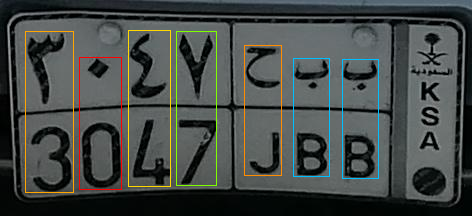

In [ ]:
images2[12]

In [ ]:
!pip install easyocr

In [ ]:
import cv2
import easyocr
import numpy as np

In [ ]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])  # You can add more languages in the list

# Convert ndarray to image format
# Ensure the array is in the proper format (BGR if using OpenCV)
image = images2[9]  # It's already in the expected BGR format

# Use EasyOCR to read the text from the image
results = reader.readtext(image)

# Print out the results
for (bbox, text, prob) in results:
    print(f"Detected text: {text} (Confidence: {prob})")
    print(f"Bounding box: {bbox}")

Detected text: 6 (Confidence: 0.10850901520108724)
Bounding box: [[393, 75], [422, 75], [422, 154], [393, 154]]


In [ ]:
reader = easyocr.Reader(['en'])

image = images2[12]

results = reader.readtext(image)

def get_best_result(results):
    highest_conf_results = []

    for result in results:
        bbox, text, prob = result

        if prob > 0.4:
            highest_conf_results.append((bbox, text, prob))

    return highest_conf_results

sorted_results = sorted(results, key=lambda r: r[0][0][0])

filtered_results = get_best_result(sorted_results)

final_text = ''.join([text for (_, text, _) in filtered_results])

print("Final text (left to right with highest confidence):", final_text)

Final text (left to right with highest confidence): 30JBB


In [ ]:
yolo_boxes = results[0].boxes.data

yolo_boxes = yolo_boxes.cpu().numpy()

image_array = images2[0]

reader = easyocr.Reader(['en'])

# Define function to crop image based on bounding box and apply OCR
def process_bounding_box(image, box, reader):
    x_min, y_min, x_max, y_max = map(int, box[:4])

    # Crop the image according to the bounding box
    cropped_img = image[y_min:y_max, x_min:x_max]

    # Use EasyOCR to detect text in the cropped region
    results = reader.readtext(cropped_img)

    # Get the best result based on confidence
    if results:
        highest_confidence = max(results, key=lambda res: res[2])
        text, confidence = highest_confidence[1], highest_confidence[2]
        return text, confidence
    else:
        return '', 0

# Loop through each YOLO bounding box and get the best character
final_text = ''
for box in yolo_boxes:
    character, confidence = process_bounding_box(image_array, box, reader)

    # Only consider results with good confidence (you can adjust this threshold)
    if confidence > 0.5:
        final_text += character

# Print the final concatenated text
print("Final recognized text:", final_text)

Final recognized text: 3
